<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/jessy/NDVI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd

In [2]:
cloud_project = 'heat-index-forecasting'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "Sinait": ee.Geometry.Point([120.459762, 17.89019]).buffer(25000),
    "Tayabas": ee.Geometry.Point([121.596575, 14.018428]).buffer(25000),
    "Tanay": ee.Geometry.Point([121.36927, 14.581167]).buffer(25000),
    "Tuguegarao": ee.Geometry.Point([121.758469, 17.647678]).buffer(25000),
    "Virac": ee.Geometry.Point([124.209834, 13.576558]).buffer(25000),
}

start_date = '2014-01-01'
end_date = '2024-01-01'

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_7TDKVSyKvBdmMqW?ref=4i2o6


In [3]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract and process NDVI from VIIRS CDR dataset with scaling and interpolation.

    Dataset: NOAA/CDR/VIIRS/NDVI/V1
    Docs: https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_VIIRS_NDVI_V1
    Scale factor: 0.0001
    Valid range: -1 to 1
    Native resolution: ~5566m
    """

    viirs_ndvi = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").filterBounds(geometry).filterDate(start_date, end_date)

    print(f"Processing NDVI for {station_name}...")

    def extract_values(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

        ndvi = img.select('NDVI').multiply(0.0001)  # apply scale factor
        ndvi = ndvi.updateMask(ndvi.gte(-1).And(ndvi.lte(1)))

        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=5566,
            bestEffort=True,
            maxPixels=1e9
        )

        return ee.Feature(None, stats).set('date', date)

    # Map and convert
    features = viirs_ndvi.map(extract_values)
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No NDVI data for {station_name}")
        return df

    # Process timeseries
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range).reset_index().rename(columns={"index": "date"})

    g["NDVI_original"] = g["NDVI"]
    g["NDVI_linear"] = g["NDVI"].interpolate("linear", limit_direction="both")
    g["NDVI_spline"] = g["NDVI"].interpolate("spline", order=2, limit_direction="both")

    out_file = f"{station_name}_NDVI.csv"
    g[["date", "NDVI_original", "NDVI_linear", "NDVI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g


In [4]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDVI for Sinait...
Saved Sinait_NDVI.csv (3653 rows)
Processing NDVI for Tayabas...
Saved Tayabas_NDVI.csv (3653 rows)
Processing NDVI for Tanay...
Saved Tanay_NDVI.csv (3653 rows)
Processing NDVI for Tuguegarao...
Saved Tuguegarao_NDVI.csv (3653 rows)
Processing NDVI for Virac...
Saved Virac_NDVI.csv (3653 rows)


In [5]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for Sinait:


,date,NDVI,NDVI_original,NDVI_linear,NDVI_spline
0,2014-01-01,0.713275,0.713275,0.713275,0.713275
1,2014-01-02,0.709804,0.709804,0.709804,0.709804
2,2014-01-03,0.660702,0.660702,0.660702,0.660702
3,2014-01-04,0.335103,0.335103,0.335103,0.335103
4,2014-01-05,0.711326,0.711326,0.711326,0.711326


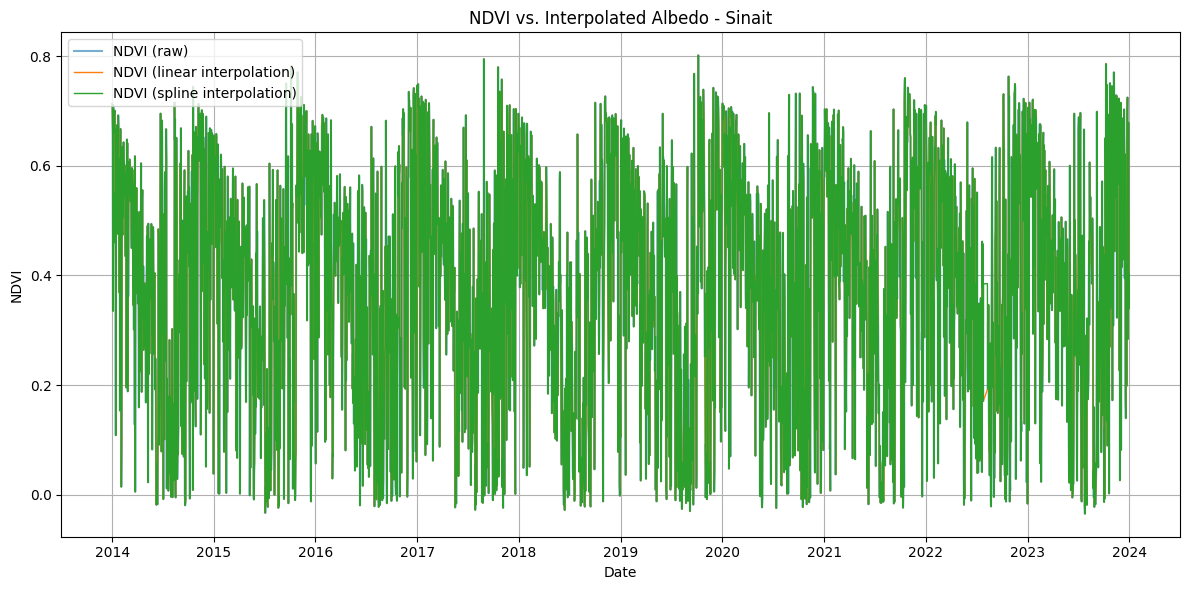

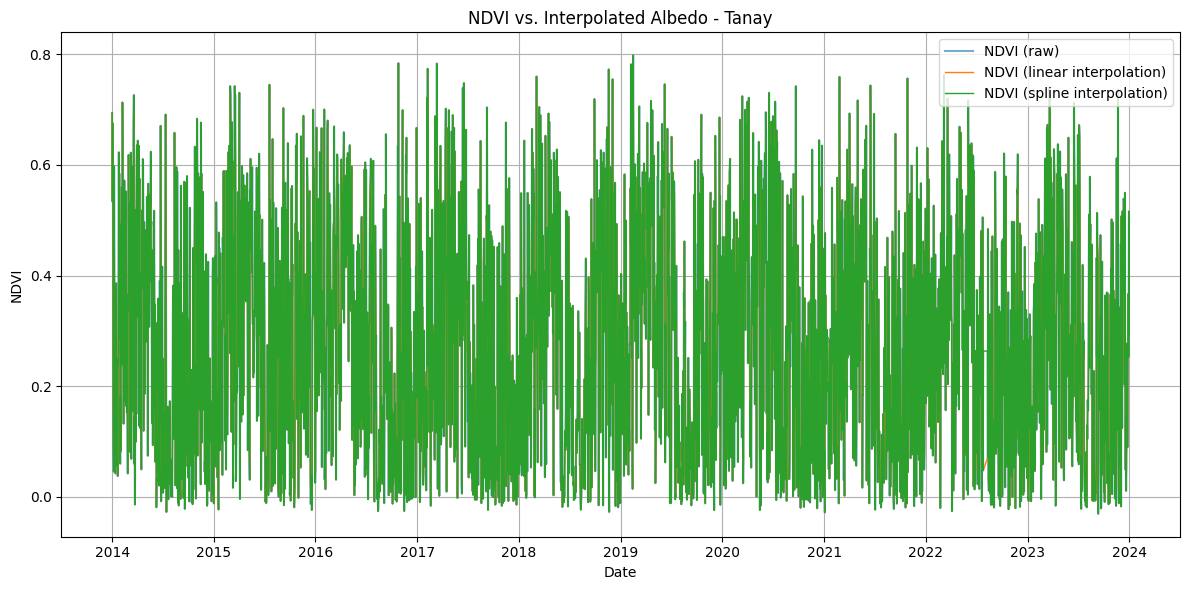

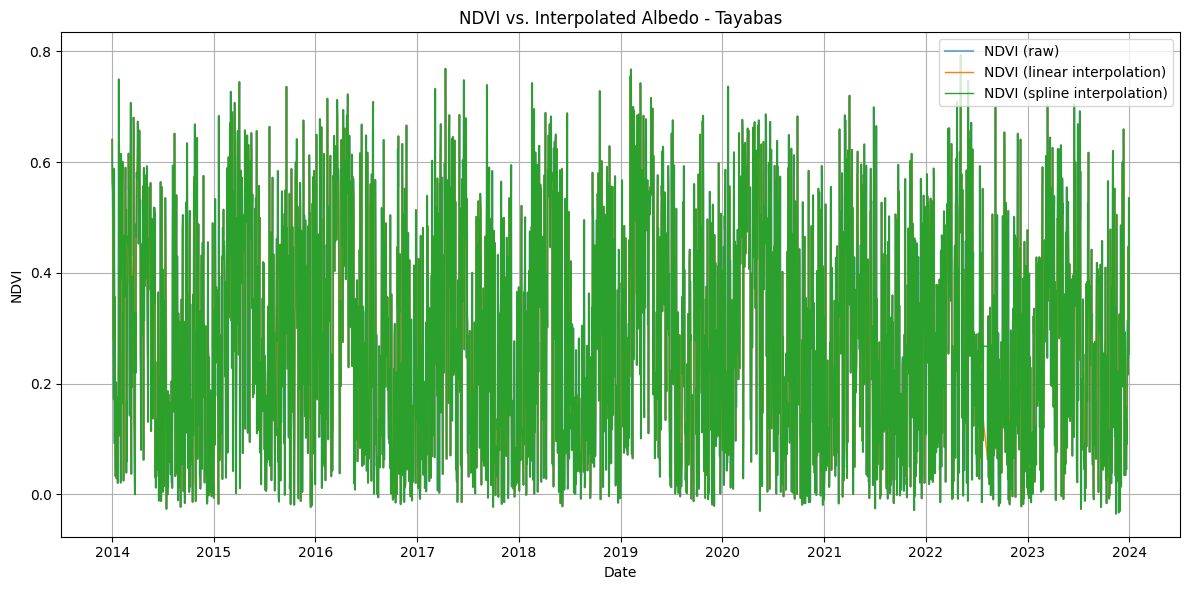

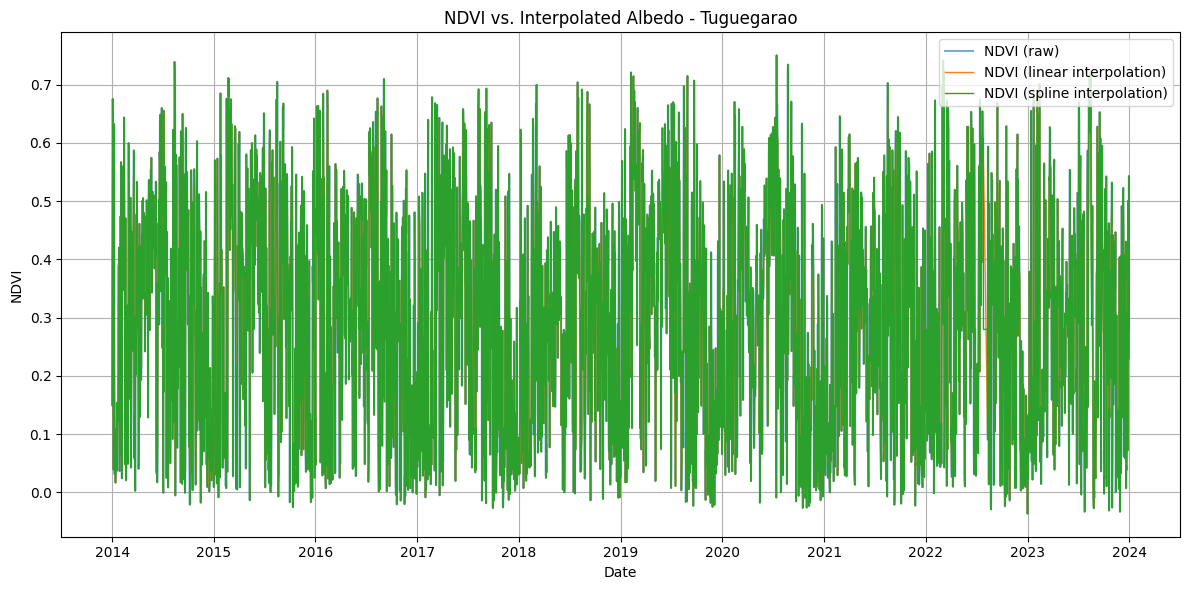

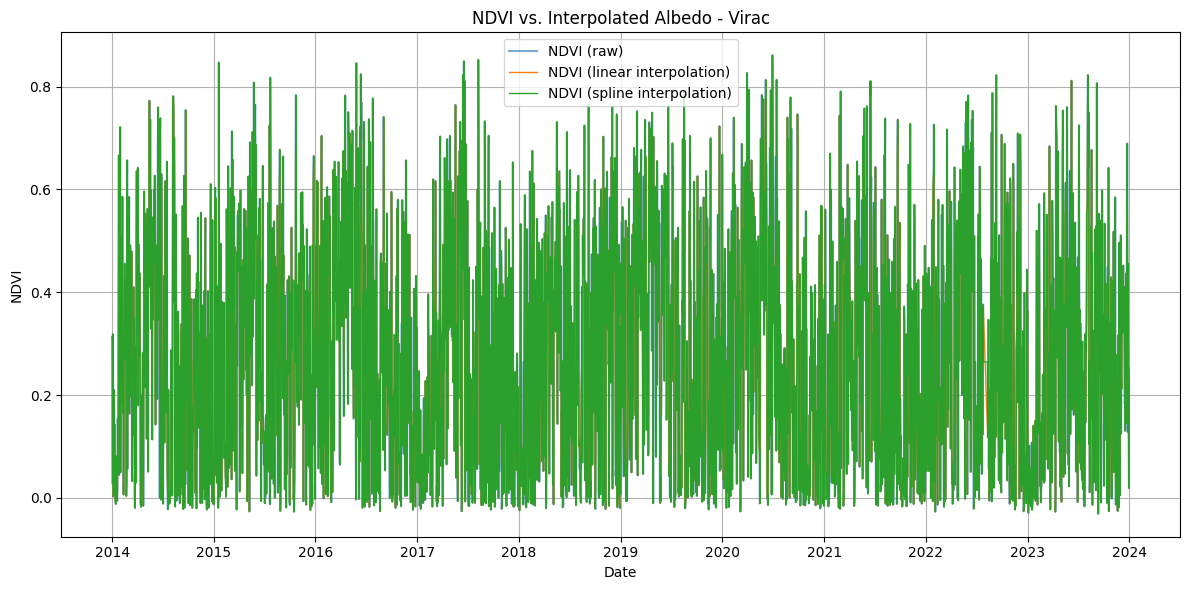

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_values(csv_file, station_name):
    # Load CSV (expects columns: date, NDVI_original, NDVI_linear, NDVI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["NDVI_original"], label="NDVI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDVI_linear"], label="NDVI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDVI_spline"], label="NDVI (spline interpolation)", linewidth=1)


    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.title(f"NDVI vs. Interpolated Albedo - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

station_names = ["Sinait", "Tanay", "Tayabas", "Tuguegarao", "Virac"]
for station in station_names:
    csv_file = f"{station}_NDVI.csv"
    plot_values(csv_file, station)